In [1]:
import numpy as np
import glob
import re

from aicsimageio import AICSImage, readers
from pathlib import Path
from matplotlib import pyplot as plt

from blimp.preprocessing.illumination_correction import IlluminationCorrection

22-Feb-24 12:11:04 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


# Correct illumination

Search images of the correct channel in the input directories

In [2]:
images_dir_1 = Path("/srv/scratch/berrylab/z3532965/systems_Ti2/202402_BleachChase_mCherry-POLR2A/20240205_182717_724/OME-TIFF-MIP/")
images_dir_2 = Path("/srv/scratch/berrylab/z3532965/systems_Ti2/202402_BleachChase_mCherry-POLR2A/20240208_085709_941/OME-TIFF-MIP/")
images_dir_3 = Path("/srv/scratch/berrylab/z3532965/systems_Ti2/202402_BleachChase_mCherry-POLR2A/20240211_185909_905/OME-TIFF-MIP/")
images_dir_4 = Path("/srv/scratch/berrylab/z3532965/systems_Ti2/202402_BleachChase_mCherry-POLR2A/20240214_161030_815/OME-TIFF-MIP/")
images_dir_5 = Path("/srv/scratch/berrylab/z3532965/systems_Ti2/202402_BleachChase_mCherry-POLR2A/20240219_161952_674/OME-TIFF-MIP/")
image_files = glob.glob(str(images_dir_1 / "*TRITC*.tiff")) + \
    glob.glob(str(images_dir_2 / "*TRITC*.tiff")) + \
    glob.glob(str(images_dir_3 / "*TRITC*.tiff")) + \
    glob.glob(str(images_dir_4 / "*TRITC*.tiff")) + \
    glob.glob(str(images_dir_5 / "*TRITC*.tiff")) 

Although these are timelapse data, we only want to correct the spatial illumination bias initially.

We take the every 3rd timepoint from those and load as AICSImages

In [3]:
images = [AICSImage(f, reader=readers.ome_tiff_reader.OmeTiffReader) for f in image_files]
reference_images = []
for image in images:
    reference_images.extend([AICSImage(image.get_image_dask_data('YX',Z=0,C=0,T=t)) for t in list(range(0, image.dims.T, 3))])

In [4]:
len(reference_images)

4788

Fit a ``blimp.IlluminationCorrection`` object

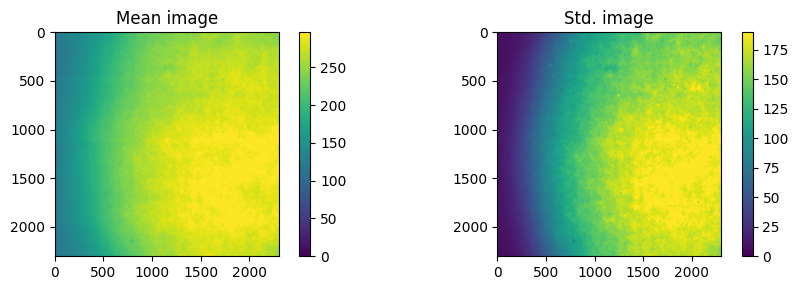

In [5]:
illumination_correction = IlluminationCorrection(
    reference_images=reference_images,
    timelapse=False,
    smoothness_flatfield=1.0)
illumination_correction.plot()

# Save illumination correction object to disk

The ``blimp.IlluminationCorrection`` object can be persisted on disk to be later applied when analysing images

In [6]:
illumcorr_filename = "/srv/scratch/berrylab/z3532965/systems_Ti2/202402_BleachChase_mCherry-POLR2A/ILLUMCORR/illumination_correction.pkl"

In [7]:
illumination_correction.save(Path(illumcorr_filename))

# Check results

IlluminationCorrection can be applied using the ``correct()`` method of the ``blimp.IlluminationCorrection`` object

In [8]:
illumination_correction = IlluminationCorrection(from_file=illumcorr_filename)

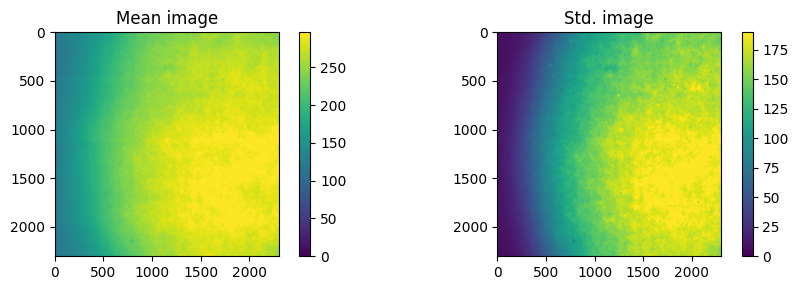

In [9]:
illumination_correction.plot()

In [10]:
raw = AICSImage(image_files[300], reader=readers.ome_tiff_reader.OmeTiffReader)
corrected = illumination_correction.correct(raw)

In [11]:
#illumination_correction.mean_image.get_image_data("YX", C=1, Z=0, T=0)
illumination_correction.mean_mean_image

[240.07269563699217]

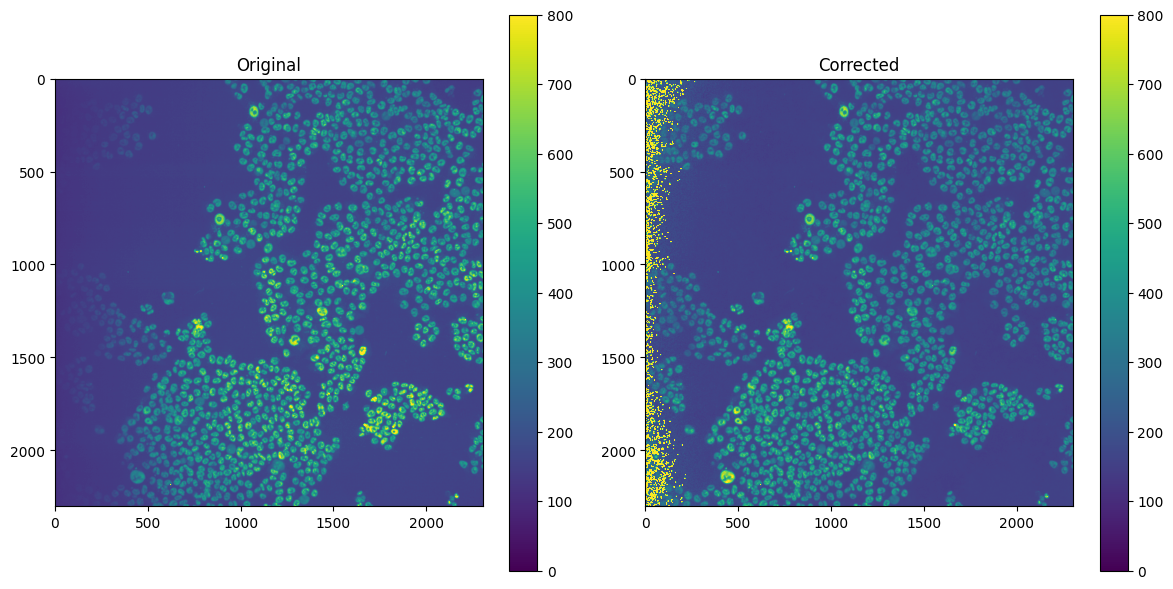

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
im = axes[0].imshow(raw.get_image_data('YX',C=0,T=0), vmin=0, vmax=800)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Original")
im = axes[1].imshow(corrected.get_image_data('YX',C=0,T=0), vmin=0, vmax=800)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Corrected")
fig.tight_layout()

Will have to crop part of these images (from say 500: on the X-axis)